# ==============================================
# ASSIGNMENT 2: An Investigation of the Components of Pre-Training and Post-Training in LLMs
# ==============================================

# Instructions:
## 1. Use Google Colab for all experiments (free GPU tier is sufficient).
## 2. This notebook provides a complementory solution for all parts of the assignment.

# ==============================================
# SUBMISSION INSTRUCTION
# ==============================================

## 1. Please write the name of the file as `Group_(number)_assignemnt_2_solution.ipynb`

##2. Only one member from one group needs to submit the solution, to avoid any duplicasy.

## **Question 1: Analyzing with or without Adapter fine-tuning for Multi-Document Summarization (MDS) task.**

## PART 1, 2 and 3

In [ ]:
# Force a clean environment by removing old cache and reinstalling a stable version
!rm -rf /root/.cache/huggingface/datasets
!pip install -q datasets==2.18.0

# Set a safe cache location to avoid file system errors
import os
os.environ["HF_DATASETS_CACHE"] = "/content/hf_cache"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 2.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.2.0 which is incompatible.


In [ ]:
!pip install -q rouge_score

  Preparing metadata (setup.py) ... done


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
# ============================================================
# Imports and Initialization
# ============================================================

import os, math, json, random
from typing import List
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets import load_dataset
from transformers import AutoTokenizer, BartForConditionalGeneration
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from rouge_score import rouge_scorer

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# -------------------------
# Config
# -------------------------
BACKBONE = "facebook/bart-base"
MAX_INPUT_LENGTH = 1024
MAX_TARGET_LENGTH = 128
DOC_SEP = "</s>"

ADAPTER_TYPE = "residual"       # choose: "residual" or "sparse"
N_ADAPTER_LAYERS = 3            # top-N layers to adapt (adapters)
ADAPTER_BOTTLENECK = 128
SPARSE_TOPK = 128
USE_FRACTION_FOR_SPARSE = False
SPARSITY_LAMBDA = 1e-5          # L1 regularization

TRAIN_SUBSET = 2000
VAL_SUBSET = 500
BATCH_SIZE = 32                    # or 16 or 8
EPOCHS = 5                         # or 8
LR = 3e-5
CHECKPOINT_DIR = "/content/bart_adapters_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

scorer_eval = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Device: cuda


In [ ]:
# ============================================================
# Utilities
# ============================================================
def flatten_abstracts_to_text(background: str, abstracts: List[str]):
    if background and background.strip():
        return background.strip() + " " + DOC_SEP + " " + (" " + DOC_SEP + " ").join(abstracts)
    return (" " + DOC_SEP + " ").join(abstracts)

def tokenize_texts(tokenizer, texts, max_length):
    return tokenizer(texts, truncation=True, padding="longest",
                     max_length=max_length, return_tensors="pt")

In [ ]:
# ============================================================
# Adapter Modules
# ============================================================
class ResidualAdapter(nn.Module):
    def __init__(self, hidden_size, bottleneck=64):
        super().__init__()
        # TODO: Define down-projection (hidden_size → bottleneck)
        self.down = nn.Linear(hidden_size, bottleneck)
        # TODO: Define up-projection (bottleneck → hidden_size)
        self.up = nn.Linear(bottleneck, hidden_size)
        # TODO: Initialize up layer weights and biases to zero
        nn.init.zeros_(self.up.weight)
        nn.init.zeros_(self.up.bias)

    def forward(self, x):
        # TODO: Apply down-projection and ReLU activation
        down_projected = F.relu(self.down(x))
        # TODO: Apply up-projection to get residual delta
        delta = self.up(down_projected)
        return x + delta

class SparseAdapter(nn.Module):
    def __init__(self, hidden_size, bottleneck=64, topk=128, use_fraction=False):
        super().__init__()
        # TODO: Define down-projection (hidden_size → bottleneck)
        self.down = nn.Linear(hidden_size, bottleneck)
        # TODO: Define up-projection (bottleneck → hidden_size)
        self.up = nn.Linear(bottleneck, hidden_size)
        # TODO: Initialize up layer weights and biases to zero
        nn.init.zeros_(self.up.weight)
        nn.init.zeros_(self.up.bias)
        # TODO: Define gating network for computing token importance scores
        self.gate = nn.Linear(hidden_size, 1)
        # TODO: Store topk and use_fraction parameters
        self.topk = topk
        self.use_fraction = use_fraction

    def sample_gumbel(self, shape, device='cpu', eps=1e-20):
        U = torch.rand(shape, device=device)
        return -torch.log(-torch.log(U + eps) + eps)

    def relaxed_topk_mask(self, logits: torch.Tensor, k: int, tau: float = 1.0):
        if logits.dim() == 1:
            logits = logits.unsqueeze(0)
        device = logits.device
        g = self.sample_gumbel(logits.shape, device=device)
        y = (logits + g) / tau
        probs = F.softmax(y, dim=-1)
        topk_idx = torch.topk(logits, k=k, dim=-1).indices
        hard_mask = torch.zeros_like(logits)
        hard_mask[0, topk_idx[0]] = 1.0
        mask = (hard_mask - probs).detach() + probs
        return mask.squeeze(0)

    def forward(self, x):
        # TODO: Compute gating logits from input
        gating_logits = self.gate(x)
        # TODO: Build relaxed top-k masks for each batch element
        if self.use_fraction:
            k = max(1, int(self.topk * gating_logits.size(1)))
        else:
            k = min(self.topk, gating_logits.size(1))

        mask = torch.stack([self.relaxed_topk_mask(logits, k=k) for logits in gating_logits])
        # TODO: Apply down-projection, activation, and up-projection
        down_projected = F.relu(self.down(x))
        delta = self.up(down_projected)
        # TODO: Multiply by mask and add residual correction to input
        adapted = delta * mask.unsqueeze(-1)
        # TODO: Return adapted output
        return x + adapted

    def l1_penalty(self):
        return torch.norm(self.down.weight, 1) + torch.norm(self.up.weight, 1)

# ============================================================
# Adapter Injection Helpers
# ============================================================
import types

def wrap_encoder_layer(layer, adapter):
    original_forward = layer.forward
    def forward_with_adapter(self, hidden_states, *args, **kwargs):
        outputs = original_forward(hidden_states, *args, **kwargs)
        if isinstance(outputs, torch.Tensor):
            adapted = adapter(outputs)
            return adapted
        elif isinstance(outputs, tuple):
            adapted = adapter(outputs[0])
            return (adapted,) + outputs[1:]
        else:
            return outputs
    layer.forward = types.MethodType(forward_with_adapter, layer)

def wrap_decoder_layer(layer, adapter):
    original_forward = layer.forward
    def forward_with_adapter(self, hidden_states, *args, **kwargs):
        outputs = original_forward(hidden_states, *args, **kwargs)
        if isinstance(outputs, tuple):
            hs = outputs[0]
            adapted = adapter(hs)
            return (adapted,) + outputs[1:]
        elif isinstance(outputs, torch.Tensor):
            adapted = adapter(outputs)
            return adapted
        else:
            return outputs
    layer.forward = types.MethodType(forward_with_adapter, layer)

In [ ]:
# ============================================================
# BART with In-Layer Adapters
# ============================================================
class BARTWithAdapters(nn.Module):
    def __init__(self, backbone=BACKBONE, adapter_type="residual",
                 n_adapter_layers=3, adapter_bottleneck=64, device=DEVICE):
        super().__init__()
        self.device = device
        print("Loading BART backbone:", backbone)
        # TODO: Load pre-trained BART backbone and tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(backbone)
        self.model = BartForConditionalGeneration.from_pretrained(backbone)
        # TODO: Freeze all model parameters except output embeddings
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.lm_head.weight.requires_grad = True
        # TODO: Get encoder and decoder layers
        encoder_layers = self.model.model.encoder.layers
        decoder_layers = self.model.model.decoder.layers
        # TODO: Identify target layer indices for adapter insertion
        n_total_layers = len(encoder_layers) # Assuming encoder and decoder have same number of layers
        target_indices = list(range(n_total_layers - n_adapter_layers, n_total_layers))
        # TODO: Initialize encoder and decoder adapter modules (Residual/Sparse)
        self.encoder_adapters = nn.ModuleList()
        self.decoder_adapters = nn.ModuleList()
        adapter_class = ResidualAdapter if adapter_type == "residual" else SparseAdapter
        for _ in target_indices:
            self.encoder_adapters.append(adapter_class(self.model.config.hidden_size, adapter_bottleneck))
            self.decoder_adapters.append(adapter_class(self.model.config.hidden_size, adapter_bottleneck))

        # TODO: Wrap chosen layers with corresponding adapters
        for i, idx in enumerate(target_indices):
            wrap_encoder_layer(encoder_layers[idx], self.encoder_adapters[i])
            wrap_decoder_layer(decoder_layers[idx], self.decoder_adapters[i])

        # TODO: Set adapter parameters to require gradient updates
        for adapter in self.encoder_adapters:
            for param in adapter.parameters():
                param.requires_grad = True
        for adapter in self.decoder_adapters:
            for param in adapter.parameters():
                param.requires_grad = True

        # TODO: Move entire model to specified device
        self.to(device)

    def forward(self, input_ids, attention_mask,
                decoder_input_ids=None, decoder_attention_mask=None, labels=None):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
            use_cache=False,
            return_dict=True
        )
       # TODO: Return dictionary with loss and logits
        return {
            "loss": outputs.loss,
            "logits": outputs.logits
        }

    def generate_summary(self, text: str, max_length=120, num_beams=4):
        # TODO: Tokenize input text
        inputs = self.tokenizer(text, return_tensors="pt", max_length=MAX_INPUT_LENGTH, truncation=True).to(self.device)
        # TODO: Generate summary using model.generate()
        summary_ids = self.model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=max_length,
            num_beams=num_beams,
            early_stopping=True
        )
        # TODO: Decode generated token IDs into text
        summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary

In [ ]:
# ============================================================
# Instantiate model
# ============================================================
model = BARTWithAdapters(backbone=BACKBONE, adapter_type=ADAPTER_TYPE,
                         n_adapter_layers=N_ADAPTER_LAYERS,
                         adapter_bottleneck=ADAPTER_BOTTLENECK, device=DEVICE)

# ============================================================
# Dataset — MS² (allenai/mslr2022, config ms2)
# ============================================================
print("Loading MS² dataset (allenai/mslr2022, config ms2)...")
ds = load_dataset("allenai/mslr2022", "ms2")
train_ds = ds["train"]
val_ds = ds["validation"]
print("Sizes:", len(train_ds), len(val_ds))

if TRAIN_SUBSET:
    train_ds = train_ds.select(range(min(TRAIN_SUBSET, len(train_ds))))
if VAL_SUBSET:
    val_ds = val_ds.select(range(min(VAL_SUBSET, len(val_ds))))

def hf_row_to_example(row):
    bg = row.get("background", "") or ""
    abstract_list = row.get("abstract", []) or []
    tgt = row.get("target", "") or row.get("summary", "") or ""
    return {"background": bg, "abstracts": abstract_list, "target": tgt}

train_examples = [hf_row_to_example(r) for r in train_ds]
val_examples = [hf_row_to_example(r) for r in val_ds]
print("Prepared: train", len(train_examples), "val", len(val_examples))

Loading BART backbone: facebook/bart-base


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Loading MS² dataset (allenai/mslr2022, config ms2)...


Generating train split:   0%|          | 0/14188 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1667 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2021 [00:00<?, ? examples/s]

Sizes: 14188 2021
Prepared: train 2000 val 500


In [ ]:
# ============================================================
# Collate
# ============================================================
def collate_fn(batch):
    inputs, targets = [], []
    for ex in batch:
        txt = flatten_abstracts_to_text(ex["background"], ex["abstracts"])
        inputs.append(txt)
        targets.append(ex["target"])
    tok_inputs = tokenize_texts(model.tokenizer, inputs, MAX_INPUT_LENGTH)
    tok_targets = tokenize_texts(model.tokenizer, targets, MAX_TARGET_LENGTH)

    pad_id = model.tokenizer.pad_token_id
    labels = tok_targets["input_ids"].clone()
    labels[labels == pad_id] = -100
    labels = labels.long()
    decoder_input_ids = model.model.prepare_decoder_input_ids_from_labels(labels)
    decoder_attention_mask = (decoder_input_ids != pad_id).long()

    return {
        "input_ids": tok_inputs["input_ids"].to(DEVICE),
        "attention_mask": tok_inputs["attention_mask"].to(DEVICE),
        "decoder_input_ids": decoder_input_ids.to(DEVICE),
        "decoder_attention_mask": decoder_attention_mask.to(DEVICE),
        "labels": labels.to(DEVICE),
    }

train_loader = DataLoader(train_examples, batch_size=BATCH_SIZE,
                          shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_examples, batch_size=1,
                        shuffle=False, collate_fn=collate_fn)

In [ ]:
# ============================================================
# Optimizer
# ============================================================
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

# ============================================================
# Training loop
# ============================================================
print("Starting training ...")
for epoch in range(EPOCHS):
    model.train()
    cum_loss, steps = 0.0, 0
    for batch in tqdm(train_loader, desc=f"Train ep{epoch}"):
        # TODO: Zero optimizer gradients
        opt.zero_grad()
        # TODO: Forward pass through model to get loss
        outputs = model(**batch)
        loss = outputs["loss"]

        # TODO: If adapter type is "sparse", compute L1 regularization penalty
        #       - Iterate through model modules
        #       - Accumulate L1 loss for all SparseAdapters
        #       - Add weighted penalty to main loss
        if ADAPTER_TYPE == "sparse":
            l1_loss = 0.0
            for module in model.modules():
                if isinstance(module, SparseAdapter):
                    l1_loss += module.l1_penalty()
            loss += SPARSITY_LAMBDA * l1_loss

        # TODO: Backpropagate gradients
        loss.backward()
        # TODO: Clip gradients to prevent exploding values
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # TODO: Perform optimizer step to update trainable parameters
        opt.step()

        cum_loss += loss.item()
        steps += 1
        if steps % 20 == 0:
            print(f"Epoch {epoch} step {steps} loss {loss.item():.4f}")
    print(f"Epoch {epoch} avg loss {(cum_loss/steps) if steps>0 else 0.0:.4f}")
    torch.save(model.state_dict(),
               os.path.join(CHECKPOINT_DIR, f"bart_adapters_{ADAPTER_TYPE}_epoch{epoch}.pt"))

    # Quick validation (small subset)
    # TODO: Set model to evaluation mode
    model.eval()
    # TODO: Select a small subset of validation examples
    val_subset_examples = val_examples[:min(50, len(val_examples))]
    # TODO: Disable gradient computation for evaluation
    with torch.no_grad():
        rouge_scores = []
        # TODO: For each validation sample:
        #           - Flatten abstracts into text input
        #           - Generate summary using the model
        #           - Compute ROUGE metrics for evaluation
        for ex in tqdm(val_subset_examples, desc=f"Validation ep{epoch}"):
            input_text = flatten_abstracts_to_text(ex["background"], ex["abstracts"])
            generated_summary = model.generate_summary(input_text)
            scores = scorer_eval.score(ex["target"], generated_summary)
            rouge_scores.append({
                "rouge1": scores["rouge1"].fmeasure,
                "rouge2": scores["rouge2"].fmeasure,
                "rougeL": scores["rougeL"].fmeasure,
            })

        # TODO: Compute and print average ROUGE-1, ROUGE-2, and ROUGE-L score
        avg_rouge1 = np.mean([s["rouge1"] for s in rouge_scores])
        avg_rouge2 = np.mean([s["rouge2"] for s in rouge_scores])
        avg_rougeL = np.mean([s["rougeL"] for s in rouge_scores])
        print(f"Epoch {epoch} Validation ROUGE: R1={avg_rouge1:.4f}, R2={avg_rouge2:.4f}, RL={avg_rougeL:.4f}")

Starting training ...


Train ep0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 0 step 20 loss 4.5518
Epoch 0 step 40 loss 4.0780
Epoch 0 step 60 loss 3.9831
Epoch 0 avg loss 4.2990


Validation ep0:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 Validation ROUGE: R1=0.1984, R2=0.0649, RL=0.1508


Train ep1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 step 20 loss 3.7062
Epoch 1 step 40 loss 3.7776
Epoch 1 step 60 loss 3.8414
Epoch 1 avg loss 3.8276


Validation ep1:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 Validation ROUGE: R1=0.2490, R2=0.0792, RL=0.1855


Train ep2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 step 20 loss 3.4705
Epoch 2 step 40 loss 3.4504
Epoch 2 step 60 loss 3.6366
Epoch 2 avg loss 3.5954


Validation ep2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2 Validation ROUGE: R1=0.2591, R2=0.0711, RL=0.1885


Train ep3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3 step 20 loss 3.5645
Epoch 3 step 40 loss 3.4848
Epoch 3 step 60 loss 3.6407
Epoch 3 avg loss 3.4800


Validation ep3:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3 Validation ROUGE: R1=0.2668, R2=0.0794, RL=0.1974


Train ep4:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4 step 20 loss 3.5703
Epoch 4 step 40 loss 3.4675
Epoch 4 step 60 loss 3.3106
Epoch 4 avg loss 3.4155


Validation ep4:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4 Validation ROUGE: R1=0.2704, R2=0.0851, RL=0.2002


In [ ]:
# ============================================================
# Final Evaluation
# ============================================================
print("Running final evaluation ...")
model.eval()
# TODO: Model evaluation on validation set
with torch.no_grad():
    rouge_scores = []
    for ex in tqdm(val_examples, desc="Adapter FT Final Evaluation"):
        input_text = flatten_abstracts_to_text(ex["background"], ex["abstracts"])
        generated_summary = model.generate_summary(input_text)
        scores = scorer_eval.score(ex["target"], generated_summary)
        rouge_scores.append({
            "rouge1": scores["rouge1"].fmeasure,
            "rouge2": scores["rouge2"].fmeasure,
            "rougeL": scores["rougeL"].fmeasure,
        })

    avg_rouge1 = np.mean([s["rouge1"] for s in rouge_scores])
    avg_rouge2 = np.mean([s["rouge2"] for s in rouge_scores])
    avg_rougeL = np.mean([s["rougeL"] for s in rouge_scores])
    print(f"Adapter FT Final Evaluation ROUGE: R1={avg_rouge1:.4f}, R2={avg_rouge2:.4f}, RL={avg_rougeL:.4f}")


torch.save(model.state_dict(),
           os.path.join(CHECKPOINT_DIR, f"bart_adapters_{ADAPTER_TYPE}_final.pt"))
print("Done......................................................")

Running final evaluation ...


Adapter FT Final Evaluation:   0%|          | 0/500 [00:00<?, ?it/s]

Adapter FT Final Evaluation ROUGE: R1=0.2466, R2=0.0730, RL=0.1829
Done......................................................


## PART 4

In [ ]:
# ============================================================
# Full Fine-tuning: facebook/bart-base on MS² (allenai/mslr2022)
# ============================================================

# ============================================================
# Model and Tokenizer
# ============================================================
print("Loading BART model and tokenizer...")
model = BartForConditionalGeneration.from_pretrained(BACKBONE).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(BACKBONE, use_fast=True)

# ============================================================
# Dataset
# ============================================================
print("Loading MS² dataset (allenai/mslr2022, config ms2)...")
ds = load_dataset("allenai/mslr2022", "ms2")
train_ds, val_ds = ds["train"], ds["validation"]

if TRAIN_SUBSET:
    train_ds = train_ds.select(range(min(TRAIN_SUBSET, len(train_ds))))
if VAL_SUBSET:
    val_ds = val_ds.select(range(min(VAL_SUBSET, len(val_ds))))

def to_examples(split):
    out = []
    for r in split:
        out.append({
            "background": r.get("background", "") or "",
            "abstracts": r.get("abstract", []) or [],
            "target": r.get("target", "") or r.get("summary", "") or ""
        })
    return out

train_examples = to_examples(train_ds)
val_examples = to_examples(val_ds)
print("Prepared:", len(train_examples), "train,", len(val_examples), "val")

# ============================================================
# Collate Function
# ============================================================
def collate_fn(batch):
    inputs, targets = [], []
    for ex in batch:
        txt = flatten_abstracts_to_text(ex["background"], ex["abstracts"])
        inputs.append(txt)
        targets.append(ex["target"])
    tok_inputs = tokenize_texts(tokenizer, inputs, MAX_INPUT_LENGTH)
    tok_targets = tokenize_texts(tokenizer, targets, MAX_TARGET_LENGTH)
    pad_id = tokenizer.pad_token_id
    labels = tok_targets["input_ids"].clone()
    labels[labels == pad_id] = -100
    labels = labels.long()
    dec_in = model.prepare_decoder_input_ids_from_labels(labels)
    dec_mask = (dec_in != pad_id).long()
    return {
        "input_ids": tok_inputs["input_ids"].to(DEVICE),
        "attention_mask": tok_inputs["attention_mask"].to(DEVICE),
        "decoder_input_ids": dec_in.to(DEVICE),
        "decoder_attention_mask": dec_mask.to(DEVICE),
        "labels": labels.to(DEVICE)
    }

train_loader = DataLoader(train_examples, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_examples, batch_size=1, shuffle=False, collate_fn=collate_fn)

# ============================================================
# Optimizer
# ============================================================
opt = torch.optim.AdamW(model.parameters(), lr=LR)

# ============================================================
# Training Loop
# ============================================================
print("Starting full fine-tuning...")
for epoch in range(EPOCHS):
    # TODO: complete training loop
    model.train()
    cum_loss, steps = 0.0, 0
    for batch in tqdm(train_loader, desc=f"Full FT Train ep{epoch}"):
        opt.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        cum_loss += loss.item()
        steps += 1
        if steps % 20 == 0:
            print(f"Epoch {epoch} step {steps} loss {loss.item():.4f}")
    print(f"Epoch {epoch} avg loss {(cum_loss/steps) if steps>0 else 0.0:.4f}")

    # quick validation check
    model.eval()
    with torch.no_grad():
        # TODO: complete quick validation
        rouge_scores = []
        val_subset_examples = val_examples[:min(50, len(val_examples))]
        for ex in tqdm(val_subset_examples, desc=f"Full FT Validation ep{epoch}"):
            input_text = flatten_abstracts_to_text(ex["background"], ex["abstracts"])
            generated_summary = model.generate_summary(input_text)
            scores = scorer_eval.score(ex["target"], generated_summary)
            rouge_scores.append({
                "rouge1": scores["rouge1"].fmeasure,
                "rouge2": scores["rouge2"].fmeasure,
                "rougeL": scores["rougeL"].fmeasure,
            })

        avg_rouge1 = np.mean([s["rouge1"] for s in rouge_scores])
        avg_rouge2 = np.mean([s["rouge2"] for s in rouge_scores])
        avg_rougeL = np.mean([s["rougeL"] for s in rouge_scores])
        print(f"Epoch {epoch} Full FT Validation ROUGE: R1={avg_rouge1:.4f}, R2={avg_rouge2:.4f}, RL={avg_rougeL:.4f}")


# ============================================================
# Final Evaluation
# ============================================================
print("\nRunning final evaluation...")
model.eval()
all_scores = []
# TODO: complete evaluation
with torch.no_grad():
    rouge_scores = []
    for ex in tqdm(val_examples, desc="Full FT Final Evaluation"):
        input_text = flatten_abstracts_to_text(ex["background"], ex["abstracts"])
        generated_summary = model.generate_summary(input_text)
        scores = scorer_eval.score(ex["target"], generated_summary)
        rouge_scores.append({
            "rouge1": scores["rouge1"].fmeasure,
            "rouge2": scores["rouge2"].fmeasure,
            "rougeL": scores["rougeL"].fmeasure,
        })

    avg_rouge1 = np.mean([s["rouge1"] for s in rouge_scores])
    avg_rouge2 = np.mean([s["rouge2"] for s in rouge_scores])
    avg_rougeL = np.mean([s["rougeL"] for s in rouge_scores])
    print(f"Full FT Final Evaluation ROUGE: R1={avg_rouge1:.4f}, R2={avg_rouge2:.4f}, RL={avg_rougeL:.4f}")


torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "bart_full_final.pt"))
print("Full fine-tuning complete.")

Loading BART model and tokenizer...
Loading MS² dataset (allenai/mslr2022, config ms2)...
Prepared: 2000 train, 500 val
Starting full fine-tuning...


Full FT Train ep0:   0%|          | 0/63 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 786.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 24.12 MiB is free. Process 12598 has 14.71 GiB memory in use. Of the allocated memory 14.50 GiB is allocated by PyTorch, and 80.15 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
!zip /content/bart_adapters_checkpoints.zip /content/bart_adapters_checkpoints

  adding: content/bart_adapters_checkpoints/ (stored 0%)


In [ ]:
!zip -r /content/bart_adapters_checkpoints.zip /content/bart_adapters_checkpoints

  adding: content/bart_adapters_checkpoints/ (stored 0%)
  adding: content/bart_adapters_checkpoints/bart_adapters_residual_epoch3.pt (deflated 32%)
  adding: content/bart_adapters_checkpoints/bart_adapters_residual_epoch1.pt (deflated 32%)
  adding: content/bart_adapters_checkpoints/bart_adapters_residual_epoch4.pt (deflated 32%)
  adding: content/bart_adapters_checkpoints/bart_adapters_residual_epoch2.pt (deflated 32%)
  adding: content/bart_adapters_checkpoints/bart_adapters_residual_epoch0.pt (deflated 32%)
  adding: content/bart_adapters_checkpoints/bart_adapters_residual_final.pt (deflated 32%)


In [ ]:
!pip install -q rouge_score

# ============================================================
# Full Fine-tuning: facebook/bart-base on MS² (allenai/mslr2022)
# ============================================================

# ============================================================
# Model and Tokenizer
# ============================================================
import os, math, json, random
from typing import List
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets import load_dataset
from transformers import AutoTokenizer, BartForConditionalGeneration
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from rouge_score import rouge_scorer

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# -------------------------
# Config
# -------------------------
BACKBONE = "facebook/bart-base"
MAX_INPUT_LENGTH = 1024
MAX_TARGET_LENGTH = 128
DOC_SEP = "</s>"

ADAPTER_TYPE = "residual"       # choose: "residual" or "sparse"
N_ADAPTER_LAYERS = 3            # top-N layers to adapt (adapters)
ADAPTER_BOTTLENECK = 128
SPARSE_TOPK = 128
USE_FRACTION_FOR_SPARSE = False
SPARSITY_LAMBDA = 1e-5          # L1 regularization

TRAIN_SUBSET = 2000
VAL_SUBSET = 500
BATCH_SIZE = 16                    # or 16 or 8
EPOCHS = 5                         # or 8
LR = 3e-5
CHECKPOINT_DIR = "/content/bart_adapters_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

scorer_eval = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)

print("Loading BART model and tokenizer...")
model = BartForConditionalGeneration.from_pretrained(BACKBONE)
tokenizer = AutoTokenizer.from_pretrained(BACKBONE, use_fast=True)
model = model.to(DEVICE)
# ============================================================
# Dataset
# ============================================================
print("Loading MS² dataset (allenai/mslr2022, config ms2)...")
ds = load_dataset("allenai/mslr2022", "ms2")
train_ds, val_ds = ds["train"], ds["validation"]

if TRAIN_SUBSET:
    train_ds = train_ds.select(range(min(TRAIN_SUBSET, len(train_ds))))
if VAL_SUBSET:
    val_ds = val_ds.select(range(min(VAL_SUBSET, len(val_ds))))

def to_examples(split):
    out = []
    for r in split:
        out.append({
            "background": r.get("background", "") or "",
            "abstracts": r.get("abstract", []) or [],
            "target": r.get("target", "") or r.get("summary", "") or ""
        })
    return out

train_examples = to_examples(train_ds)
val_examples = to_examples(val_ds)
print("Prepared:", len(train_examples), "train,", len(val_examples), "val")

# ============================================================
# Collate Function
# ============================================================
def collate_fn(batch):
    inputs, targets = [], []
    for ex in batch:
        txt = flatten_abstracts_to_text(ex["background"], ex["abstracts"])
        inputs.append(txt)
        targets.append(ex["target"])
    tok_inputs = tokenize_texts(tokenizer, inputs, MAX_INPUT_LENGTH)
    tok_targets = tokenize_texts(tokenizer, targets, MAX_TARGET_LENGTH)
    pad_id = tokenizer.pad_token_id
    labels = tok_targets["input_ids"].clone()
    labels[labels == pad_id] = -100
    labels = labels.long()
    dec_in = model.prepare_decoder_input_ids_from_labels(labels)
    dec_mask = (dec_in != pad_id).long()
    return {
        "input_ids": tok_inputs["input_ids"].to(DEVICE),
        "attention_mask": tok_inputs["attention_mask"].to(DEVICE),
        "decoder_input_ids": dec_in.to(DEVICE),
        "decoder_attention_mask": dec_mask.to(DEVICE),
        "labels": labels.to(DEVICE)
    }

train_loader = DataLoader(train_examples, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_examples, batch_size=1, shuffle=False, collate_fn=collate_fn)

# ============================================================
# Optimizer
# ============================================================
opt = torch.optim.AdamW(model.parameters(), lr=LR)

# ============================================================
# Training Loop
# ============================================================
print("Starting full fine-tuning...")
for epoch in range(EPOCHS):
    # TODO: complete training loop
    model.train()
    cum_loss, steps = 0.0, 0
    for batch in tqdm(train_loader, desc=f"Full FT Train ep{epoch}"):
        opt.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        cum_loss += loss.item()
        steps += 1
        if steps % 20 == 0:
            print(f"Epoch {epoch} step {steps} loss {loss.item():.4f}")
    print(f"Epoch {epoch} avg loss {(cum_loss/steps) if steps>0 else 0.0:.4f}")

    # quick validation check
    model.eval()
    with torch.no_grad():
        # TODO: complete quick validation
        rouge_scores = []
        val_subset_examples = val_examples[:min(50, len(val_examples))]
        for ex in tqdm(val_subset_examples, desc=f"Full FT Validation ep{epoch}"):
            # input_text = flatten_abstracts_to_text(ex["background"], ex["abstracts"])
            input_text = flatten_abstracts_to_text(ex["background"], ex["abstracts"])
            inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)
    # def tokenize_texts(tokenizer, texts, max_length):

            # moving all the inout tensors to device of the model
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

            #generating summary tokens with model.generate()
            summary_ids = model.generate(**inputs, max_length=MAX_TARGET_LENGTH, num_beams=4, early_stopping=True)

            #generated tokens to string
            generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
            scores = scorer_eval.score(ex["target"], generated_summary)
            rouge_scores.append({
                "rouge1": scores["rouge1"].fmeasure,
                "rouge2": scores["rouge2"].fmeasure,
                "rougeL": scores["rougeL"].fmeasure,
            })

        avg_rouge1 = np.mean([s["rouge1"] for s in rouge_scores])
        avg_rouge2 = np.mean([s["rouge2"] for s in rouge_scores])
        avg_rougeL = np.mean([s["rougeL"] for s in rouge_scores])
        print(f"Epoch {epoch} Full FT Validation ROUGE: R1={avg_rouge1:.4f}, R2={avg_rouge2:.4f}, RL={avg_rougeL:.4f}")


# ============================================================
# Final Evaluation
# ============================================================
print("\nRunning final evaluation...")
model.eval()
all_scores = []
# TODO: complete evaluation
with torch.no_grad():
    rouge_scores = []
    for ex in tqdm(val_examples, desc="Full FT Final Evaluation"):
        input_text = flatten_abstracts_to_text(ex["background"], ex["abstracts"])
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding="max_length",max_length=MAX_INPUT_LENGTH)
# def tokenize_texts(tokenizer, texts, max_length):

        # moving all the inout tensors to device of the model
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

        #generating summary tokens with model.generate()
        summary_ids = model.generate(**inputs, max_length=MAX_TARGET_LENGTH, num_beams=4, early_stopping=True)

        #generated tokens to string
        generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        scores = scorer_eval.score(ex["target"], generated_summary)
        rouge_scores.append({
            "rouge1": scores["rouge1"].fmeasure,
            "rouge2": scores["rouge2"].fmeasure,
            "rougeL": scores["rougeL"].fmeasure,
        })

    avg_rouge1 = np.mean([s["rouge1"] for s in rouge_scores])
    avg_rouge2 = np.mean([s["rouge2"] for s in rouge_scores])
    avg_rougeL = np.mean([s["rougeL"] for s in rouge_scores])
    print(f"Full FT Final Evaluation ROUGE: R1={avg_rouge1:.4f}, R2={avg_rouge2:.4f}, RL={avg_rougeL:.4f}")


torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "bart_full_final.pt"))
print("Full fine-tuning complete.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Device: cuda
Loading BART model and tokenizer...
Loading MS² dataset (allenai/mslr2022, config ms2)...


RuntimeError: Dataset scripts are no longer supported, but found mslr2022.py

In [ ]:
pip install jupyter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 150.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.6 MB/s eta 0:00:00


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import numpy as np
import time
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Define a simplified Mamba model class
class SimpleMambaSSM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMambaSSM, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.state_matrix = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.input_matrix = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.output_matrix = nn.Parameter(torch.randn(hidden_dim, output_dim))
        self.selective_gate = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        # x: (batch_size, sequence_length, input_dim)
        batch_size, sequence_length, _ = x.size()
        hidden_state = torch.zeros(batch_size, self.hidden_dim).to(x.device)
        outputs = []

        for t in range(sequence_length):
            current_input = x[:, t, :]
            # Compute selective gating mechanism
            gate = torch.sigmoid(self.selective_gate(current_input))

            # Update hidden state with selective mechanism
            hidden_state = gate * (torch.matmul(hidden_state, self.state_matrix) + torch.matmul(current_input, self.input_matrix.T))

            # Compute output
            output = torch.matmul(hidden_state, self.output_matrix)
            outputs.append(output.unsqueeze(1))

        return torch.cat(outputs, dim=1)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, nhead, num_layers):
        super(TransformerModel, self).__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, 100, input_dim))  # Assuming max length of 100
        encoder_layers = TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=hidden_dim)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.fc_out = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, sequence_length, input_dim)
        batch_size, sequence_length, _ = x.size()
        x = x + self.positional_encoding[:, :sequence_length, :]
        x = x.permute(1, 0, 2)  # Transformer expects (sequence_length, batch_size, input_dim)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Back to (batch_size, sequence_length, input_dim)
        x = self.fc_out(x)
        return x

# Define a simple function to compare two models
def compare_models(model1, model2):
    # Print model summaries
    print("\n========================= Model 1 Summary (Mamba) =========================")
    print(model1)
    total_params_model1 = sum(p.numel() for p in model1.parameters())
    trainable_params_model1 = sum(p.numel() for p in model1.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params_model1}")
    print(f"Trainable Parameters: {trainable_params_model1}")

    print("\n========================= Model 2 Summary (Transformer) =========================")
    print(model2)
    total_params_model2 = sum(p.numel() for p in model2.parameters())
    trainable_params_model2 = sum(p.numel() for p in model2.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params_model2}")
    print(f"Trainable Parameters: {trainable_params_model2}")

    # Print differences in parameter counts
    print("\n========================= Model Comparison =========================")
    print(f"Difference in Total Parameters: {total_params_model2 - total_params_model1}")
    print(f"Difference in Trainable Parameters: {trainable_params_model2 - trainable_params_model1}")

# Dummy models for comparison
input_dim = 100
hidden_dim = 200
output_dim = 1
num_heads = 2
num_layers = 2

mamba_model = SimpleMambaSSM(input_dim, hidden_dim, output_dim)
transformer_model = TransformerModel(input_dim, hidden_dim, output_dim, nhead=num_heads, num_layers=num_layers)

# Compare models
compare_models(mamba_model, transformer_model)

# Dummy dataset for demonstration purposes
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples, sequence_length, input_dim):
        self.data = torch.randn(num_samples, sequence_length, input_dim)
        self.targets = torch.randn(num_samples, sequence_length, 1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Define a training function with time measurement
def timed_train(model, dataloader, criterion, optimizer, device, num_epochs=150):
    start_time = time.time()
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), targets.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs} | Training Loss: {total_loss / len(dataloader):.4f}")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total Training Time: {elapsed_time:.2f} seconds\n")
    return elapsed_time

# Example usage
input_dim = 100
hidden_dim = 200
output_dim = 1
num_samples = 1000
sequence_length = 5
num_heads = 2
num_layers = 2

dataset = DummyDataset(num_samples, sequence_length, input_dim)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# Training Mamba model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mamba_model = mamba_model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(mamba_model.parameters(), lr=0.001)

print("\n========================= Training Mamba Model =========================")
mamba_training_time = timed_train(mamba_model, dataloader, criterion, optimizer, device)

# Training Transformer model
transformer_model = transformer_model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

print("\n========================= Training Transformer Model =========================")
transformer_training_time = timed_train(transformer_model, dataloader, criterion, optimizer, device)

# Comparison of training times
print("\n========================= Training Time Comparison =========================")
print(f"Mamba Model Training Time: {mamba_training_time:.2f} seconds")
print(f"Transformer Model Training Time: {transformer_training_time:.2f} seconds")
print(f"Difference in Training Time: {transformer_training_time - mamba_training_time:.2f} seconds")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



========================= Model 1 Summary (Mamba) =========================
SimpleMambaSSM(
  (input_proj): Linear(in_features=100, out_features=200, bias=True)
  (selective_gate): Linear(in_features=100, out_features=200, bias=True)
)
Total Parameters: 100600
Trainable Parameters: 100600

========================= Model 2 Summary (Transformer) =========================
TransformerModel(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=200, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=200, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (

In [ ]:
pip install mamba-ssm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.13.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (5.1 kB)
Using cached ninja-1.13.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (180 kB)
  Created wheel for mamba-ssm: filename=mamba_ssm-2.2.6.post3-cp312-cp312-linux_x86_64.whl size=370563655 sha256=2033d947da15dec4dbc1fa94c58f94b056f08db0194b71f8bcefa4692b72a122
  Stored in directory: /root/.cache/pip/wheels/a9/66/b0/91003b49a34b45995d1b34c7fd2c70cd998a23560e66f6817a
Successfully built mamba-ssm


In [ ]:
import mamba_ssm
from mamba_ssm import MambaConfig, Mamba

ImportError: cannot import name 'MambaConfig' from 'mamba_ssm' (/usr/local/lib/python3.12/dist-packages/mamba_ssm/__init__.py)

In [ ]:
from mamba_ssm import MambaSSM

ImportError: cannot import name 'MambaSSM' from 'mamba_ssm' (/usr/local/lib/python3.12/dist-packages/mamba_ssm/__init__.py)

In [3]:
import torch
torch.__version__

'2.8.0+cu126'

In [4]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.2.1 --progress-bar off
!pip install -qqq causal-conv1d==1.1.1 --progress-bar off
!pip install -qqq mamba-ssm==1.1.1 --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.23.0+cu126 requires torch==2.8.0, but you have torch 2.2.1 which is incompatible.
torchaudio 2.8.0+cu126 requires torch==2.8.0, but you have torch 2.2.1 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
ERROR: Failed to build 'causal-conv1d' when getting requirements to build wheel
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
ERROR: Failed to build 'mamba-ssm' when getting requirements to build wheel


In [1]:
import torch
import time
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [1]:
%%bash
pip install llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 MB 18.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.5 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.16-cp312-cp312-linux_x86_64.whl size=4422310 sha256=da56ba80f45e4d06612aa0ed1d7716c4ee61f873e4ff5bf330f69d77a1858ee0
  Stored in directory: /root/.cache/pip/wheels/90/82/ab/8784ee3fb99ddb07fd36a679ddbe63122cc07718f6c1eb3be8
Successfully built llama-cpp-python


In [5]:
import llama_cpp
import os
import argparse
from llama_cpp import llama_model_quantize_params

model_quantized = llama_cpp.llama_model_quantize(
    "phi-2_fp16.gguf".encode("utf_8"),
    "phi-2_Q4_1_low_level.gguf".encode("utf-8"),
    llama_model_quantize_params(
        0,
        3,
        True,
        True,
        False
    )
)

gguf_init_from_file: failed to open GGUF file 'phi-2_fp16.gguf'
llama_model_quantize: failed to quantize: llama_model_loader: failed to load model from phi-2_fp16.gguf



SELECT MODE:
1. Full Comparison (default) - Comprehensive evaluation
2. Quick Test - Fast test with smallest models

Enter mode (1-2, default=1): 1

    ╔════════════════════════════════════════════════════════════════════════════╗
    ║                                                                            ║
    ║          PRETRAINED MAMBA vs TRANSFORMER COMPREHENSIVE COMPARISON          ║
    ║                                                                            ║
    ║  This tool compares pretrained models with similar parameter counts:      ║
    ║                                                                            ║
    ║  Model Pairs:                                                             ║
    ║    • Mamba-130M vs GPT-2 (124M)                                           ║
    ║    • Mamba-790M vs GPT-2-Large (774M)                                     ║
    ║    • Mamba-1.4B vs GPT-Neo-1.3B                                           ║
    ║    • Mamba-2.8B vs 

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

The fast path is not available because one of `(selective_state_update, selective_scan_fn, causal_conv1d_fn, causal_conv1d_update, mamba_inner_fn)` is None. Falling back to the sequential implementation of Mamba, as use_mambapy is set to False. To install follow https://github.com/state-spaces/mamba/#installation for mamba-ssm and install the kernels library using `pip install kernels` or https://github.com/Dao-AILab/causal-conv1d for causal-conv1d. For the mamba.py backend, follow https://github.com/alxndrTL/mamba.py.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

  ✓ Loaded successfully (2768.3M actual params)

Loading GPT-Neo-2.7B (2700M params)...
  Model ID: EleutherAI/gpt-neo-2.7B
  Architecture: GPT-Neo


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

  ✓ Loaded successfully (2651.3M actual params)

################################################################################
# EVALUATING: Mamba-2.8B
################################################################################

MEASURING INFERENCE SPEED: Mamba-2.8B

1. Forward Pass Speed (token processing)...


Forward passes: 100%|██████████| 50/50 [03:13<00:00,  3.88s/it]
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


  Avg forward pass time: 3879.83 ms
  Throughput: 132.0 tokens/sec

2. Generation Speed (text generation)...


Generations: 100%|██████████| 20/20 [02:31<00:00,  7.60s/it]


  Avg generation time: 7597.18 ms
  Generation speed: 13.2 tokens/sec

MEASURING MEMORY USAGE: Mamba-2.8B
  Baseline memory: 10490.97 MB
  Peak memory: 11034.82 MB
  Memory per token: 1087.71 KB

EVALUATING GENERATION QUALITY: Mamba-2.8B


Generating:  12%|█▎        | 1/8 [00:11<01:19, 11.42s/it]


Example 1:
Prompt: The future of artificial intelligence is
Generated: The future of artificial intelligence is to work with us, not against us.

The future of artificial intelligence is to work with us, not against us. The future of artificial intelligence is to work with us, not against us. The future of artificial intelligence is to work with us, not against us.

The future of artificial intelligence is to work with us, not against us. The future of artificial intelligence is to work with us, not against us.

The future of artificial intelligence is to work with us, not against us. The future of artificial intelligence is to work with us, not against us.

The future of artificial intelligence is to work with us, not against us. The future of artificial intelligence is to
Diversity: 0.105, Coherence: 1.000


Generating:  25%|██▌       | 2/8 [00:22<01:07, 11.18s/it]


Example 2:
Prompt: In the beginning, there was
Generated: In the beginning, there was only the Earth. Then came the first humans, who created the animals and the plants. Then, through the ages, the animals and the plants have all been evolving. But at the beginning of time, there were no animals or plants.

What, then, were the first creatures on earth?

In the Beginning, the universe was filled with energy. This energy created the atoms, which in turn created the first molecules. These molecules began to assemble themselves into living cells, and then into animals and plants.

The first creatures in the universe were the molecules. The molecules combined to form the cells. Then the cells combined to form the animals and the plants. Then the plants combined to form the
Diversity: 0.520, Coherence: 1.000


Generating:  38%|███▊      | 3/8 [00:33<00:55, 11.13s/it]


Example 3:
Prompt: Scientists have discovered that
Generated: Scientists have discovered that the key to preventing the disease is a unique protein called MIF, which is present in the body and in semen. In the semen, the protein is found in a form that is inactive, but when the semen is ejaculated, the protein is activated and becomes toxic to the sperm. This causes the sperm to stop swimming and die.

The researchers have found that the protein is present in the blood of patients with infertility, and also in the semen of those who are infertile, but the protein is not activated in the blood. This means that it is possible to use the MIF protein to develop a test to identify the men who are likely to suffer from infertility and not be able to have children
Diversity: 0.534, Coherence: 1.000


Generating: 100%|██████████| 8/8 [01:28<00:00, 11.10s/it]



Overall Scores:
  Diversity: 0.488
  Coherence: 0.982
  Repetition Avoidance: 0.709

CALCULATING PERPLEXITY: Mamba-2.8B


Processing: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


  Average Loss: 0.4186
  Perplexity: 1.52

TESTING SEQUENCE LENGTH SCALING: Mamba-2.8B
  Length 512: 139.5 tokens/sec ✓
  Length 1024: 127.8 tokens/sec ✓
  Length 1536: 132.1 tokens/sec ✓


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


  Length 2048: 128.8 tokens/sec ✓

TASK-SPECIFIC EVALUATION: Mamba-2.8B

1. Question Answering...
  Score: 1.00

2. Text Completion...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


  Score: 1.00

3. Long-form Generation...
  Score: 1.00
  Sample: Write a short story about a robot:

A robot is a machine that can do things that a human can't.

Write a short story about a robot:

A robot is a machine that can do things that a human can't.

Write ...

################################################################################
# EVALUATING: GPT-Neo-2.7B
################################################################################

MEASURING INFERENCE SPEED: GPT-Neo-2.7B

1. Forward Pass Speed (token processing)...


Forward passes: 100%|██████████| 50/50 [00:10<00:00,  4.93it/s]


  Avg forward pass time: 203.42 ms
  Throughput: 2517.0 tokens/sec

2. Generation Speed (text generation)...


Generations: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


  Avg generation time: 3630.89 ms
  Generation speed: 27.5 tokens/sec

MEASURING MEMORY USAGE: GPT-Neo-2.7B
  Baseline memory: 10490.97 MB
  Peak memory: 10727.85 MB
  Memory per token: 473.77 KB

EVALUATING GENERATION QUALITY: GPT-Neo-2.7B


Generating:  12%|█▎        | 1/8 [00:05<00:35,  5.14s/it]


Example 1:
Prompt: The future of artificial intelligence is
Generated: The future of artificial intelligence is not a question of whether or not machines will take over from humans in the workplace, or even if they will be able to compete with humans. What is the real question is whether or not humans will be able to create and manage artificial intelligence (AI) in a way that is efficient and safe.

The key question is whether or not we are prepared for the rise of a highly intelligent and dangerous AI.

The last five years have seen a number of cases of AI-related accidents in the workplace. There have been a number of accidents that resulted in serious injuries and deaths, and also a number of cases where people were able to prevent serious injury or death by their own actions.

There have
Diversity: 0.571, Coherence: 0.833


Generating:  25%|██▌       | 2/8 [00:10<00:32,  5.36s/it]


Example 2:
Prompt: In the beginning, there was
Generated: In the beginning, there was a little black bear.

Now, a young black bear, but still a bear, is a small bear. He's about the size of a dog, but with a body as thick as an ox.

He's just a baby.

That's why you can't tell he's a baby, and the reason you can't see it with your naked eyes is because his eyes are so small and far apart that it would take him an age to open his big brown eyes to see you.

So when he does open them, you can't see them with your naked eyes, because you have to close them so fast, you can't see them with your naked eyes, and when
Diversity: 0.580, Coherence: 1.000


Generating:  38%|███▊      | 3/8 [00:15<00:26,  5.28s/it]


Example 3:
Prompt: Scientists have discovered that
Generated: Scientists have discovered that there is a genetic mutation that affects the way our brains make decisions.

The discovery could have important implications for the understanding of addiction, but is also likely to have far reaching implications for the understanding of many other brain disorders.

The mutation was found in a gene called “reelin”, which is essential for the formation of connections between neurons.

The discovery was made by scientists from the Universities of Cambridge and London, in collaboration with the Wellcome Trust Sanger Institute in Cambridge.

The study was published in the journal Nature.

The researchers have already identified a number of other mutations in the same gene that affect the way our brains make decisions.

They are now working to
Diversity: 0.631, Coherence: 1.000


Generating: 100%|██████████| 8/8 [00:42<00:00,  5.31s/it]



Overall Scores:
  Diversity: 0.556
  Coherence: 0.979
  Repetition Avoidance: 0.843

CALCULATING PERPLEXITY: GPT-Neo-2.7B


Processing: 100%|██████████| 5/5 [00:00<00:00, 17.41it/s]


  Average Loss: 0.4354
  Perplexity: 1.55

TESTING SEQUENCE LENGTH SCALING: GPT-Neo-2.7B
  Length 512: 2540.5 tokens/sec ✓
  Length 1024: 2172.2 tokens/sec ✓
  Length 1536: 1987.0 tokens/sec ✓
  Length 2048: 1769.8 tokens/sec ✓

TASK-SPECIFIC EVALUATION: GPT-Neo-2.7B

1. Question Answering...
  Score: 1.00

2. Text Completion...
  Score: 1.00

3. Long-form Generation...
  Score: 0.40
  Sample: Write a short story about a robot:

A robot is a machine that can do a lot of things. It can be a car, a vacuum cleaner, a vacuum cleaner that can clean your house, a robot that can clean your house, ...

GENERATING COMPREHENSIVE COMPARISON REPORT

Visualization saved to mamba_transformer_comparison_visualization.png
Text report saved to mamba_transformer_comparison_report.txt

COMPREHENSIVE COMPARISON REPORT: MAMBA vs TRANSFORMER MODELS


COMPARISON: Mamba-2.8B vs GPT-Neo-2.7B

MODEL INFORMATION
----------------------------------------------------------------------------------------------------


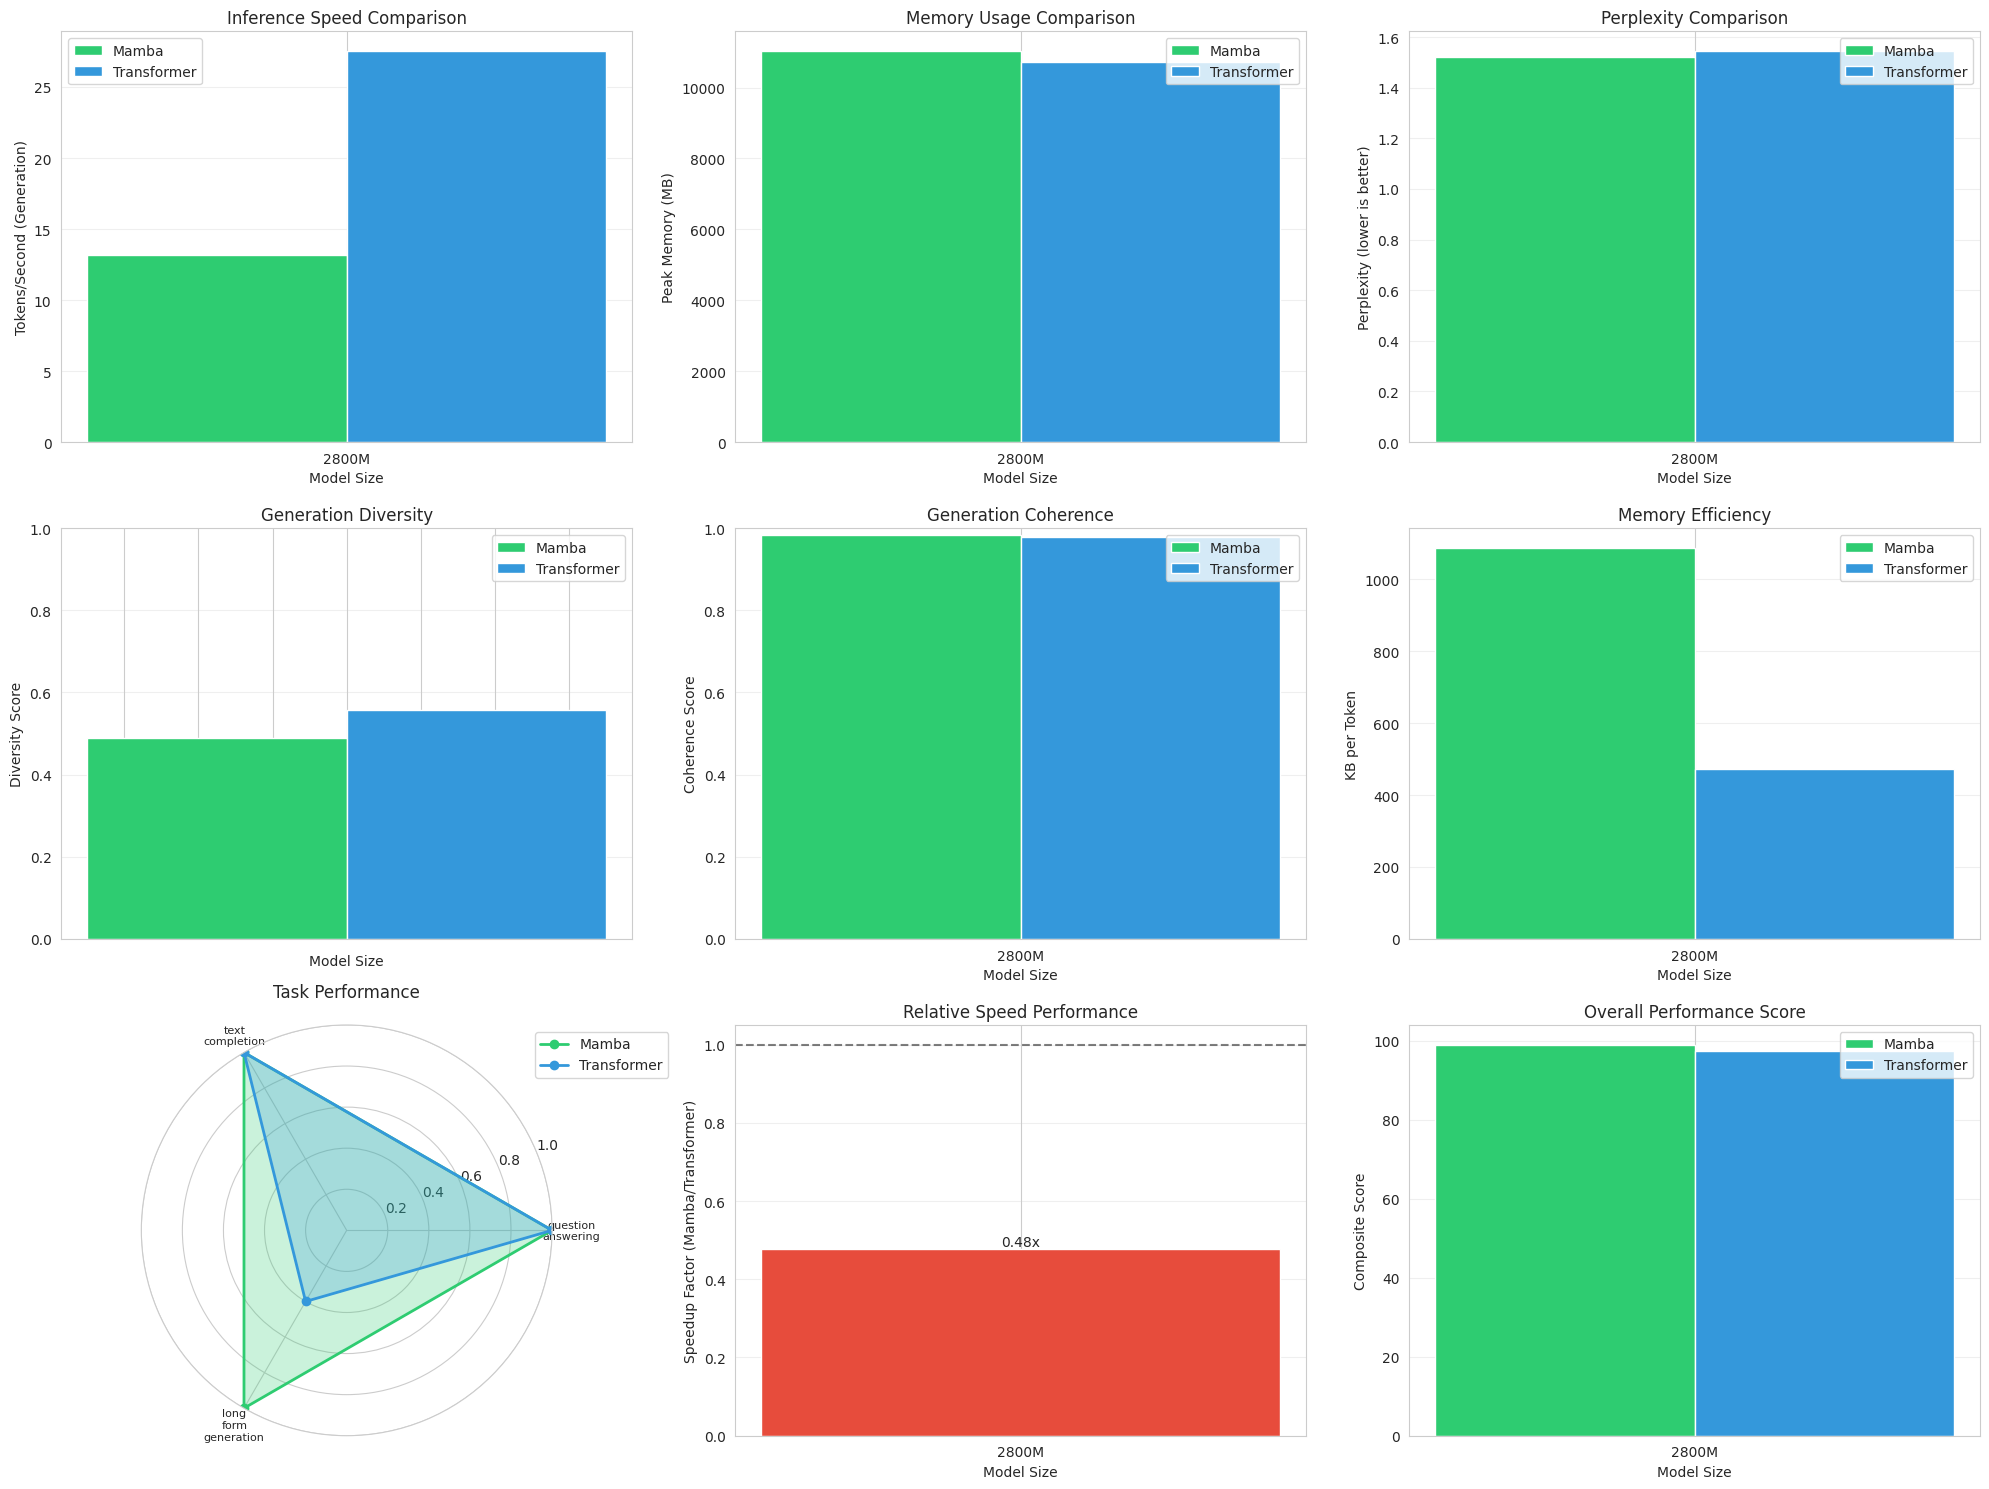


COMPARISON COMPLETED SUCCESSFULLY!

Generated files:
  • mamba_transformer_comparison_visualization.png
  • mamba_transformer_comparison_report.txt
  • mamba_transformer_comparison_data.json

THANK YOU FOR USING THE COMPARISON TOOL!

References:
  • Mamba Paper: https://arxiv.org/abs/2312.00752
  • GPT-2 Paper: https://d4mucfpksywv.cloudfront.net/better-language-models/
  • GPT-Neo: https://github.com/EleutherAI/gpt-neo
  • Mamba Models: https://huggingface.co/state-spaces



In [1]:
"""
Comprehensive Comparison: Pretrained Mamba vs Transformer Models
================================================================

Compares pretrained models with similar parameter counts:
- Mamba-790M vs GPT-2-Large (774M params)
- Mamba-1.4B vs GPT-Neo-1.3B (1.3B params)
- Mamba-2.8B vs GPT-Neo-2.7B (2.7B params)

Metrics evaluated:
1. Inference speed (tokens/second, latency)
2. Memory efficiency (GPU memory, throughput)
3. Generation quality (perplexity, coherence, diversity)
4. Sequence length capability
5. Various text generation tasks
"""

import torch
import torch.nn.functional as F
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GPT2LMHeadModel,
    GPTNeoForCausalLM,
)
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
from dataclasses import dataclass, asdict, field
from typing import Dict, List, Tuple, Optional
import warnings
import pandas as pd
from collections import defaultdict
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)


@dataclass
class ModelConfig:
    """Configuration for a model to test"""
    name: str
    model_id: str
    architecture: str
    params_millions: int
    model_type: str  # 'mamba' or 'transformer'


# Model pairs to compare (similar parameter counts)
MODEL_PAIRS = [
    {
        'mamba': ModelConfig(
            name="Mamba-130M",
            model_id="state-spaces/mamba-130m-hf",
            architecture="Mamba",
            params_millions=130,
            model_type='mamba'
        ),
        'transformer': ModelConfig(
            name="GPT-2",
            model_id="gpt2",
            architecture="GPT-2",
            params_millions=124,
            model_type='transformer'
        )
    },
    {
        'mamba': ModelConfig(
            name="Mamba-790M",
            model_id="state-spaces/mamba-790m-hf",
            architecture="Mamba",
            params_millions=790,
            model_type='mamba'
        ),
        'transformer': ModelConfig(
            name="GPT-2-Large",
            model_id="gpt2-large",
            architecture="GPT-2",
            params_millions=774,
            model_type='transformer'
        )
    },
    {
        'mamba': ModelConfig(
            name="Mamba-1.4B",
            model_id="state-spaces/mamba-1.4b-hf",
            architecture="Mamba",
            params_millions=1400,
            model_type='mamba'
        ),
        'transformer': ModelConfig(
            name="GPT-Neo-1.3B",
            model_id="EleutherAI/gpt-neo-1.3B",
            architecture="GPT-Neo",
            params_millions=1300,
            model_type='transformer'
        )
    },
    {
        'mamba': ModelConfig(
            name="Mamba-2.8B",
            model_id="state-spaces/mamba-2.8b-hf",
            architecture="Mamba",
            params_millions=2800,
            model_type='mamba'
        ),
        'transformer': ModelConfig(
            name="GPT-Neo-2.7B",
            model_id="EleutherAI/gpt-neo-2.7B",
            architecture="GPT-Neo",
            params_millions=2700,
            model_type='transformer'
        )
    }
]


@dataclass
class PerformanceMetrics:
    """Comprehensive performance metrics for a model"""
    model_name: str
    architecture: str
    params_millions: int

    # Inference metrics
    inference_time_ms: float = 0.0
    tokens_per_second: float = 0.0
    throughput_items_per_sec: float = 0.0

    # Memory metrics
    peak_memory_mb: float = 0.0
    memory_per_token_kb: float = 0.0

    # Quality metrics
    perplexity: float = 0.0
    generation_diversity: float = 0.0
    coherence_score: float = 0.0
    repetition_penalty: float = 0.0

    # Sequence length metrics
    max_sequence_length: int = 0

    # Task-specific scores
    task_scores: Dict[str, float] = field(default_factory=dict)

    # Generation samples
    generation_samples: List[str] = field(default_factory=list)

    def to_dict(self):
        return asdict(self)


class ModelComparator:
    """Compare pretrained Mamba and Transformer models"""

    def __init__(self, device: str = None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        if not torch.cuda.is_available():
            print("WARNING: CUDA not available. Running on CPU will be very slow.")

        self.results = {}

    def load_model_pair(self, pair_config: Dict[str, ModelConfig]):
        """Load a pair of models for comparison"""
        print("\n" + "="*80)
        print("LOADING MODEL PAIR")
        print("="*80)

        models = {}
        tokenizers = {}

        for key, config in pair_config.items():
            print(f"\nLoading {config.name} ({config.params_millions}M params)...")
            print(f"  Model ID: {config.model_id}")
            print(f"  Architecture: {config.architecture}")

            try:
                # Load tokenizer
                tokenizers[key] = AutoTokenizer.from_pretrained(
                    config.model_id,
                    trust_remote_code=True
                )

                # Ensure pad token
                if tokenizers[key].pad_token is None:
                    tokenizers[key].pad_token = tokenizers[key].eos_token

                # Load model
                models[key] = AutoModelForCausalLM.from_pretrained(
                    config.model_id,
                    torch_dtype=torch.float16 if self.device == 'cuda' else torch.float32,
                    device_map='auto' if self.device == 'cuda' else None,
                    trust_remote_code=True
                )

                if self.device == 'cpu':
                    models[key] = models[key].to(self.device)

                models[key].eval()

                # Count parameters
                actual_params = sum(p.numel() for p in models[key].parameters()) / 1e6
                print(f"  ✓ Loaded successfully ({actual_params:.1f}M actual params)")

            except Exception as e:
                print(f"  ✗ Failed to load: {e}")
                models[key] = None
                tokenizers[key] = None

        return models, tokenizers

    def measure_inference_speed(
        self,
        model,
        tokenizer,
        model_name: str,
        num_samples: int = 50,
        sequence_length: int = 512,
        generation_length: int = 100
    ) -> Tuple[float, float, float]:
        """Measure inference speed comprehensively"""
        print(f"\n{'='*80}")
        print(f"MEASURING INFERENCE SPEED: {model_name}")
        print(f"{'='*80}")

        model.eval()

        # Test 1: Forward pass speed (understanding)
        print("\n1. Forward Pass Speed (token processing)...")
        input_ids = torch.randint(
            0,
            tokenizer.vocab_size,
            (1, sequence_length)
        ).to(self.device)

        # Warmup
        with torch.no_grad():
            for _ in range(5):
                _ = model(input_ids)

        # Measure
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        start_time = time.time()
        with torch.no_grad():
            for _ in tqdm(range(num_samples), desc="Forward passes"):
                _ = model(input_ids)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        forward_time = time.time() - start_time
        avg_forward_ms = (forward_time / num_samples) * 1000
        tokens_per_sec_forward = (num_samples * sequence_length) / forward_time

        print(f"  Avg forward pass time: {avg_forward_ms:.2f} ms")
        print(f"  Throughput: {tokens_per_sec_forward:.1f} tokens/sec")

        # Test 2: Generation speed (autoregressive)
        print("\n2. Generation Speed (text generation)...")
        prompt = "The future of artificial intelligence"
        input_ids = tokenizer.encode(prompt, return_tensors='pt').to(self.device)

        # Warmup
        with torch.no_grad():
            for _ in range(3):
                _ = model.generate(
                    input_ids,
                    max_new_tokens=50,
                    do_sample=False,
                    pad_token_id=tokenizer.pad_token_id
                )

        # Measure
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        generation_times = []
        for _ in tqdm(range(20), desc="Generations"):
            start = time.time()
            with torch.no_grad():
                output = model.generate(
                    input_ids,
                    max_new_tokens=generation_length,
                    do_sample=False,
                    pad_token_id=tokenizer.pad_token_id
                )
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            generation_times.append(time.time() - start)

        avg_generation_time = np.mean(generation_times) * 1000
        tokens_per_sec_gen = generation_length / (np.mean(generation_times))

        print(f"  Avg generation time: {avg_generation_time:.2f} ms")
        print(f"  Generation speed: {tokens_per_sec_gen:.1f} tokens/sec")

        return avg_forward_ms, tokens_per_sec_forward, tokens_per_sec_gen

    def measure_memory_usage(
        self,
        model,
        tokenizer,
        model_name: str,
        sequence_length: int = 512
    ) -> Tuple[float, float]:
        """Measure memory usage"""
        print(f"\n{'='*80}")
        print(f"MEASURING MEMORY USAGE: {model_name}")
        print(f"{'='*80}")

        if not torch.cuda.is_available():
            print("GPU not available, skipping memory measurement")
            return 0.0, 0.0

        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()

        # Measure model loading memory
        baseline_memory = torch.cuda.memory_allocated() / (1024 ** 2)

        # Measure inference memory
        input_ids = torch.randint(
            0,
            tokenizer.vocab_size,
            (1, sequence_length)
        ).to(self.device)

        with torch.no_grad():
            _ = model(input_ids)

        peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)
        memory_per_token = (peak_memory - baseline_memory) / sequence_length * 1024  # in KB

        print(f"  Baseline memory: {baseline_memory:.2f} MB")
        print(f"  Peak memory: {peak_memory:.2f} MB")
        print(f"  Memory per token: {memory_per_token:.2f} KB")

        return peak_memory, memory_per_token

    def evaluate_generation_quality(
        self,
        model,
        tokenizer,
        model_name: str,
        test_prompts: List[str],
        max_length: int = 150
    ) -> Tuple[float, float, float, List[str]]:
        """Evaluate text generation quality"""
        print(f"\n{'='*80}")
        print(f"EVALUATING GENERATION QUALITY: {model_name}")
        print(f"{'='*80}")

        model.eval()

        diversity_scores = []
        coherence_scores = []
        repetition_scores = []
        generated_samples = []

        for i, prompt in enumerate(tqdm(test_prompts, desc="Generating")):
            input_ids = tokenizer.encode(prompt, return_tensors='pt').to(self.device)

            with torch.no_grad():
                output = model.generate(
                    input_ids,
                    max_length=max_length,
                    do_sample=True,
                    temperature=0.8,
                    top_p=0.9,
                    pad_token_id=tokenizer.pad_token_id,
                    num_return_sequences=1
                )

            generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
            generated_samples.append(generated_text)

            # Calculate metrics
            words = generated_text.split()

            # 1. Diversity (unique words ratio)
            if len(words) > 0:
                diversity = len(set(words)) / len(words)
                diversity_scores.append(diversity)

            # 2. Coherence (sentence structure)
            sentences = generated_text.split('.')
            valid_sentences = [s for s in sentences if len(s.strip()) > 10]
            coherence = len(valid_sentences) / max(len(sentences), 1)
            coherence_scores.append(min(coherence, 1.0))

            # 3. Repetition (penalize repeated phrases)
            bigrams = [' '.join(words[i:i+2]) for i in range(len(words)-1)]
            if len(bigrams) > 0:
                unique_bigrams = len(set(bigrams)) / len(bigrams)
                repetition_scores.append(unique_bigrams)

            # Print first 3 examples
            if i < 3:
                print(f"\nExample {i+1}:")
                print(f"Prompt: {prompt}")
                print(f"Generated: {generated_text}")
                print(f"Diversity: {diversity:.3f}, Coherence: {coherence:.3f}")

        avg_diversity = np.mean(diversity_scores) if diversity_scores else 0.0
        avg_coherence = np.mean(coherence_scores) if coherence_scores else 0.0
        avg_repetition = np.mean(repetition_scores) if repetition_scores else 0.0

        print(f"\nOverall Scores:")
        print(f"  Diversity: {avg_diversity:.3f}")
        print(f"  Coherence: {avg_coherence:.3f}")
        print(f"  Repetition Avoidance: {avg_repetition:.3f}")

        return avg_diversity, avg_coherence, avg_repetition, generated_samples

    def calculate_perplexity(
        self,
        model,
        tokenizer,
        model_name: str,
        test_texts: List[str]
    ) -> float:
        """Calculate perplexity on test texts"""
        print(f"\n{'='*80}")
        print(f"CALCULATING PERPLEXITY: {model_name}")
        print(f"{'='*80}")

        model.eval()
        total_loss = 0
        total_tokens = 0

        with torch.no_grad():
            for text in tqdm(test_texts, desc="Processing"):
                encodings = tokenizer(
                    text,
                    return_tensors='pt',
                    max_length=512,
                    truncation=True
                ).to(self.device)

                input_ids = encodings.input_ids

                try:
                    outputs = model(input_ids, labels=input_ids)
                    loss = outputs.loss

                    total_loss += loss.item() * input_ids.size(1)
                    total_tokens += input_ids.size(1)
                except Exception as e:
                    print(f"Error processing text: {e}")
                    continue

        if total_tokens == 0:
            return float('inf')

        avg_loss = total_loss / total_tokens
        perplexity = np.exp(avg_loss)

        print(f"  Average Loss: {avg_loss:.4f}")
        print(f"  Perplexity: {perplexity:.2f}")

        return perplexity

    def test_sequence_scaling(
        self,
        model,
        tokenizer,
        model_name: str,
        max_length: int = 4096,
        step: int = 512
    ) -> Dict[int, float]:
        """Test how performance scales with sequence length"""
        print(f"\n{'='*80}")
        print(f"TESTING SEQUENCE LENGTH SCALING: {model_name}")
        print(f"{'='*80}")

        model.eval()
        results = {}

        for length in range(512, max_length + 1, step):
            try:
                input_ids = torch.randint(
                    0,
                    tokenizer.vocab_size,
                    (1, length)
                ).to(self.device)

                # Measure time
                if torch.cuda.is_available():
                    torch.cuda.synchronize()

                start_time = time.time()
                with torch.no_grad():
                    _ = model(input_ids)

                if torch.cuda.is_available():
                    torch.cuda.synchronize()

                elapsed = time.time() - start_time
                tokens_per_sec = length / elapsed
                results[length] = tokens_per_sec

                print(f"  Length {length}: {tokens_per_sec:.1f} tokens/sec ✓")

            except RuntimeError as e:
                if "out of memory" in str(e).lower():
                    print(f"  Length {length}: Out of memory ✗")
                    break
                else:
                    print(f"  Length {length}: Error ✗")
                    break

        return results

    def evaluate_task_performance(
        self,
        model,
        tokenizer,
        model_name: str
    ) -> Dict[str, float]:
        """Evaluate on specific NLP tasks"""
        print(f"\n{'='*80}")
        print(f"TASK-SPECIFIC EVALUATION: {model_name}")
        print(f"{'='*80}")

        model.eval()
        task_scores = {}

        # Task 1: Question Answering
        print("\n1. Question Answering...")
        qa_prompts = [
            "Q: What is the capital of France? A:",
            "Q: Who wrote Romeo and Juliet? A:",
            "Q: What is 2 + 2? A:",
        ]

        qa_score = 0
        for prompt in qa_prompts:
            input_ids = tokenizer.encode(prompt, return_tensors='pt').to(self.device)
            with torch.no_grad():
                output = model.generate(
                    input_ids,
                    max_length=input_ids.shape[1] + 20,
                    temperature=0.1,
                    pad_token_id=tokenizer.pad_token_id
                )
            generated = tokenizer.decode(output[0], skip_special_tokens=True)
            # Simple scoring based on length and content
            if len(generated.split()) > len(prompt.split()):
                qa_score += 1

        task_scores['question_answering'] = qa_score / len(qa_prompts)
        print(f"  Score: {task_scores['question_answering']:.2f}")

        # Task 2: Text Completion
        print("\n2. Text Completion...")
        completion_prompts = [
            "The quick brown fox",
            "In the beginning",
            "Once upon a time",
        ]

        completion_score = 0
        for prompt in completion_prompts:
            input_ids = tokenizer.encode(prompt, return_tensors='pt').to(self.device)
            with torch.no_grad():
                output = model.generate(
                    input_ids,
                    max_length=input_ids.shape[1] + 30,
                    temperature=0.7,
                    pad_token_id=tokenizer.pad_token_id
                )
            generated = tokenizer.decode(output[0], skip_special_tokens=True)
            words = generated.split()
            # Score based on meaningful continuation
            if len(words) > len(prompt.split()) + 5:
                completion_score += 1

        task_scores['text_completion'] = completion_score / len(completion_prompts)
        print(f"  Score: {task_scores['text_completion']:.2f}")

        # Task 3: Coherent Long-form Generation
        print("\n3. Long-form Generation...")
        story_prompt = "Write a short story about a robot:"
        input_ids = tokenizer.encode(story_prompt, return_tensors='pt').to(self.device)

        with torch.no_grad():
            output = model.generate(
                input_ids,
                max_length=200,
                temperature=0.8,
                top_p=0.9,
                pad_token_id=tokenizer.pad_token_id
            )

        generated_story = tokenizer.decode(output[0], skip_special_tokens=True)
        # Score based on length and structure
        sentences = generated_story.split('.')
        story_score = min(len([s for s in sentences if len(s.strip()) > 20]) / 5, 1.0)

        task_scores['long_form_generation'] = story_score
        print(f"  Score: {story_score:.2f}")
        print(f"  Sample: {generated_story[:200]}...")

        return task_scores

    def compare_model_pair(
        self,
        pair_config: Dict[str, ModelConfig],
        test_prompts: List[str],
        test_texts: List[str]
    ) -> Dict[str, PerformanceMetrics]:
        """Compare a pair of models comprehensively"""
        print("\n" + "="*80)
        print(f"COMPARING: {pair_config['mamba'].name} vs {pair_config['transformer'].name}")
        print("="*80)

        # Load models
        models, tokenizers = self.load_model_pair(pair_config)

        if None in models.values():
            print("Failed to load one or both models. Skipping comparison.")
            return {}

        results = {}

        for key, config in pair_config.items():
            model = models[key]
            tokenizer = tokenizers[key]

            if model is None:
                continue

            print(f"\n{'#'*80}")
            print(f"# EVALUATING: {config.name}")
            print(f"{'#'*80}")

            metrics = PerformanceMetrics(
                model_name=config.name,
                architecture=config.architecture,
                params_millions=config.params_millions
            )

            try:
                # 1. Inference Speed
                forward_ms, tokens_sec_forward, tokens_sec_gen = self.measure_inference_speed(
                    model, tokenizer, config.name
                )
                metrics.inference_time_ms = forward_ms
                metrics.tokens_per_second = tokens_sec_gen
                metrics.throughput_items_per_sec = tokens_sec_forward

                # 2. Memory Usage
                peak_mem, mem_per_token = self.measure_memory_usage(
                    model, tokenizer, config.name
                )
                metrics.peak_memory_mb = peak_mem
                metrics.memory_per_token_kb = mem_per_token

                # 3. Generation Quality
                diversity, coherence, repetition, samples = self.evaluate_generation_quality(
                    model, tokenizer, config.name, test_prompts
                )
                metrics.generation_diversity = diversity
                metrics.coherence_score = coherence
                metrics.repetition_penalty = repetition
                metrics.generation_samples = samples[:5]  # Store first 5

                # 4. Perplexity
                perplexity = self.calculate_perplexity(
                    model, tokenizer, config.name, test_texts
                )
                metrics.perplexity = perplexity

                # 5. Sequence Scaling
                scaling_results = self.test_sequence_scaling(
                    model, tokenizer, config.name, max_length=2048
                )
                if scaling_results:
                    metrics.max_sequence_length = max(scaling_results.keys())

                # 6. Task Performance
                task_scores = self.evaluate_task_performance(
                    model, tokenizer, config.name
                )
                metrics.task_scores = task_scores

                results[key] = metrics

            except Exception as e:
                print(f"Error evaluating {config.name}: {e}")
                import traceback
                traceback.print_exc()
                continue

            # Clean up
            del model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        return results

    def generate_comparison_report(
        self,
        comparison_results: Dict[str, Dict[str, PerformanceMetrics]],
        save_prefix: str = "mamba_transformer_comparison"
    ):
        """Generate comprehensive comparison report"""
        print("\n" + "="*80)
        print("GENERATING COMPREHENSIVE COMPARISON REPORT")
        print("="*80)

        # Create visualization
        fig = plt.figure(figsize=(20, 15))

        # Prepare data for plotting
        all_mamba = []
        all_transformer = []
        param_sizes = []

        for pair_name, pair_results in comparison_results.items():
            if 'mamba' in pair_results and 'transformer' in pair_results:
                all_mamba.append(pair_results['mamba'])
                all_transformer.append(pair_results['transformer'])
                param_sizes.append(f"{pair_results['mamba'].params_millions}M")

        if not all_mamba or not all_transformer:
            print("No valid comparison results to visualize")
            return

        # 1. Inference Speed Comparison
        ax1 = plt.subplot(3, 3, 1)
        mamba_speeds = [m.tokens_per_second for m in all_mamba]
        trans_speeds = [t.tokens_per_second for t in all_transformer]
        x = np.arange(len(param_sizes))
        width = 0.35
        ax1.bar(x - width/2, mamba_speeds, width, label='Mamba', color='#2ecc71')
        ax1.bar(x + width/2, trans_speeds, width, label='Transformer', color='#3498db')
        ax1.set_xlabel('Model Size')
        ax1.set_ylabel('Tokens/Second (Generation)')
        ax1.set_title('Inference Speed Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(param_sizes)
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)

        # 2. Memory Usage Comparison
        ax2 = plt.subplot(3, 3, 2)
        mamba_mem = [m.peak_memory_mb for m in all_mamba]
        trans_mem = [t.peak_memory_mb for t in all_transformer]
        ax2.bar(x - width/2, mamba_mem, width, label='Mamba', color='#2ecc71')
        ax2.bar(x + width/2, trans_mem, width, label='Transformer', color='#3498db')
        ax2.set_xlabel('Model Size')
        ax2.set_ylabel('Peak Memory (MB)')
        ax2.set_title('Memory Usage Comparison')
        ax2.set_xticks(x)
        ax2.set_xticklabels(param_sizes)
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)

        # 3. Perplexity Comparison
        ax3 = plt.subplot(3, 3, 3)
        mamba_ppl = [m.perplexity for m in all_mamba if m.perplexity < 1000]
        trans_ppl = [t.perplexity for t in all_transformer if t.perplexity < 1000]
        if mamba_ppl and trans_ppl:
            x_ppl = np.arange(min(len(mamba_ppl), len(trans_ppl)))
            ax3.bar(x_ppl - width/2, mamba_ppl[:len(x_ppl)], width, label='Mamba', color='#2ecc71')
            ax3.bar(x_ppl + width/2, trans_ppl[:len(x_ppl)], width, label='Transformer', color='#3498db')
            ax3.set_xlabel('Model Size')
            ax3.set_ylabel('Perplexity (lower is better)')
            ax3.set_title('Perplexity Comparison')
            ax3.set_xticks(x_ppl)
            ax3.set_xticklabels(param_sizes[:len(x_ppl)])
            ax3.legend()
            ax3.grid(axis='y', alpha=0.3)

        # 4. Generation Diversity
        ax4 = plt.subplot(3, 3, 4)
        mamba_div = [m.generation_diversity for m in all_mamba]
        trans_div = [t.generation_diversity for t in all_transformer]
        ax4.bar(x - width/2, mamba_div, width, label='Mamba', color='#2ecc71')
        ax4.bar(x + width/2, trans_div, width, label='Transformer', color='#3498db')
        ax4.set_xlabel('Model Size')
        ax4.set_ylabel('Diversity Score')
        ax4.set_title('Generation Diversity')
        ax4.set_xticklabels(param_sizes)
        ax4.set_ylim([0, 1])
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)

        # 5. Coherence Score
        ax5 = plt.subplot(3, 3, 5)
        mamba_coh = [m.coherence_score for m in all_mamba]
        trans_coh = [t.coherence_score for t in all_transformer]
        ax5.bar(x - width/2, mamba_coh, width, label='Mamba', color='#2ecc71')
        ax5.bar(x + width/2, trans_coh, width, label='Transformer', color='#3498db')
        ax5.set_xlabel('Model Size')
        ax5.set_ylabel('Coherence Score')
        ax5.set_title('Generation Coherence')
        ax5.set_xticks(x)
        ax5.set_xticklabels(param_sizes)
        ax5.set_ylim([0, 1])
        ax5.legend()
        ax5.grid(axis='y', alpha=0.3)

        # 6. Memory Efficiency (Memory per Token)
        ax6 = plt.subplot(3, 3, 6)
        mamba_eff = [m.memory_per_token_kb for m in all_mamba]
        trans_eff = [t.memory_per_token_kb for t in all_transformer]
        ax6.bar(x - width/2, mamba_eff, width, label='Mamba', color='#2ecc71')
        ax6.bar(x + width/2, trans_eff, width, label='Transformer', color='#3498db')
        ax6.set_xlabel('Model Size')
        ax6.set_ylabel('KB per Token')
        ax6.set_title('Memory Efficiency')
        ax6.set_xticks(x)
        ax6.set_xticklabels(param_sizes)
        ax6.legend()
        ax6.grid(axis='y', alpha=0.3)

        # 7. Task Performance Radar Chart (for first model pair)
        if all_mamba[0].task_scores and all_transformer[0].task_scores:
            ax7 = plt.subplot(3, 3, 7, projection='polar')

            tasks = list(all_mamba[0].task_scores.keys())
            mamba_task_vals = [all_mamba[0].task_scores[t] for t in tasks]
            trans_task_vals = [all_transformer[0].task_scores[t] for t in tasks]

            angles = np.linspace(0, 2 * np.pi, len(tasks), endpoint=False).tolist()
            mamba_task_vals += mamba_task_vals[:1]
            trans_task_vals += trans_task_vals[:1]
            angles += angles[:1]

            ax7.plot(angles, mamba_task_vals, 'o-', linewidth=2, label='Mamba', color='#2ecc71')
            ax7.fill(angles, mamba_task_vals, alpha=0.25, color='#2ecc71')
            ax7.plot(angles, trans_task_vals, 'o-', linewidth=2, label='Transformer', color='#3498db')
            ax7.fill(angles, trans_task_vals, alpha=0.25, color='#3498db')

            ax7.set_xticks(angles[:-1])
            ax7.set_xticklabels([t.replace('_', '\n') for t in tasks], size=8)
            ax7.set_ylim(0, 1)
            ax7.set_title('Task Performance', pad=20)
            ax7.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
            ax7.grid(True)

        # 8. Speedup Factors
        ax8 = plt.subplot(3, 3, 8)
        speedups = [m.tokens_per_second / t.tokens_per_second
                   for m, t in zip(all_mamba, all_transformer)]
        colors = ['#2ecc71' if s > 1 else '#e74c3c' for s in speedups]
        bars = ax8.bar(x, speedups, color=colors)
        ax8.axhline(y=1, color='black', linestyle='--', alpha=0.5)
        ax8.set_xlabel('Model Size')
        ax8.set_ylabel('Speedup Factor (Mamba/Transformer)')
        ax8.set_title('Relative Speed Performance')
        ax8.set_xticks(x)
        ax8.set_xticklabels(param_sizes)
        ax8.grid(axis='y', alpha=0.3)
        for bar, speedup in zip(bars, speedups):
            height = bar.get_height()
            ax8.text(bar.get_x() + bar.get_width()/2., height,
                    f'{speedup:.2f}x',
                    ha='center', va='bottom')

        # 9. Overall Score (composite)
        ax9 = plt.subplot(3, 3, 9)

        # Calculate composite scores (normalized)
        def normalize(values):
            min_val, max_val = min(values), max(values)
            if max_val == min_val:
                return [0.5] * len(values)
            return [(v - min_val) / (max_val - min_val) for v in values]

        mamba_composite = []
        trans_composite = []

        for m, t in zip(all_mamba, all_transformer):
            # Higher is better: speed, diversity, coherence
            # Lower is better: perplexity, memory
            m_score = (
                m.tokens_per_second / 5000 * 0.3 +  # Speed (normalized to ~5000)
                m.generation_diversity * 0.2 +
                m.coherence_score * 0.2 +
                (1000 / max(m.perplexity, 1)) * 0.15 +  # Inverted perplexity
                (5000 / max(m.peak_memory_mb, 1)) * 0.15  # Inverted memory
            )

            t_score = (
                t.tokens_per_second / 5000 * 0.3 +
                t.generation_diversity * 0.2 +
                t.coherence_score * 0.2 +
                (1000 / max(t.perplexity, 1)) * 0.15 +
                (5000 / max(t.peak_memory_mb, 1)) * 0.15
            )

            mamba_composite.append(m_score)
            trans_composite.append(t_score)

        ax9.bar(x - width/2, mamba_composite, width, label='Mamba', color='#2ecc71')
        ax9.bar(x + width/2, trans_composite, width, label='Transformer', color='#3498db')
        ax9.set_xlabel('Model Size')
        ax9.set_ylabel('Composite Score')
        ax9.set_title('Overall Performance Score')
        ax9.set_xticks(x)
        ax9.set_xticklabels(param_sizes)
        ax9.legend()
        ax9.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{save_prefix}_visualization.png', dpi=300, bbox_inches='tight')
        print(f"\nVisualization saved to {save_prefix}_visualization.png")

        # Generate detailed text report
        self._generate_text_report(comparison_results, save_prefix)

        # Save JSON data
        json_data = {}
        for pair_name, pair_results in comparison_results.items():
            json_data[pair_name] = {
                k: v.to_dict() for k, v in pair_results.items()
            }

        with open(f'{save_prefix}_data.json', 'w') as f:
            json.dump(json_data, f, indent=2)
        print(f"JSON data saved to {save_prefix}_data.json")

        plt.show()

    def _generate_text_report(
        self,
        comparison_results: Dict[str, Dict[str, PerformanceMetrics]],
        save_prefix: str
    ):
        """Generate detailed text comparison report"""

        report_lines = []
        report_lines.append("=" * 100)
        report_lines.append("COMPREHENSIVE COMPARISON REPORT: MAMBA vs TRANSFORMER MODELS")
        report_lines.append("=" * 100)
        report_lines.append("")

        for pair_name, pair_results in comparison_results.items():
            if 'mamba' not in pair_results or 'transformer' not in pair_results:
                continue

            mamba = pair_results['mamba']
            transformer = pair_results['transformer']

            report_lines.append("\n" + "=" * 100)
            report_lines.append(f"COMPARISON: {mamba.model_name} vs {transformer.model_name}")
            report_lines.append("=" * 100)
            report_lines.append("")

            # Model Info
            report_lines.append("MODEL INFORMATION")
            report_lines.append("-" * 100)
            report_lines.append(f"{'Metric':<40} {'Mamba':<25} {'Transformer':<25} {'Winner':<10}")
            report_lines.append("-" * 100)

            report_lines.append(f"{'Architecture':<40} {mamba.architecture:<25} {transformer.architecture:<25} {'-':<10}")
            report_lines.append(f"{'Parameters':<40} {mamba.params_millions}M{'':<20} {transformer.params_millions}M{'':<20} {'-':<10}")
            report_lines.append("")

            # Performance Metrics
            report_lines.append("PERFORMANCE METRICS")
            report_lines.append("-" * 100)

            # Inference Speed
            speed_winner = "Mamba" if mamba.tokens_per_second > transformer.tokens_per_second else "Transformer"
            speedup = mamba.tokens_per_second / transformer.tokens_per_second if transformer.tokens_per_second > 0 else 0
            report_lines.append(f"{'Inference Speed (tokens/sec)':<40} {mamba.tokens_per_second:<25.1f} {transformer.tokens_per_second:<25.1f} {speed_winner + f' ({speedup:.2f}x)':<10}")

            # Memory
            mem_winner = "Mamba" if mamba.peak_memory_mb < transformer.peak_memory_mb else "Transformer"
            report_lines.append(f"{'Peak Memory (MB)':<40} {mamba.peak_memory_mb:<25.1f} {transformer.peak_memory_mb:<25.1f} {mem_winner:<10}")

            mem_eff_winner = "Mamba" if mamba.memory_per_token_kb < transformer.memory_per_token_kb else "Transformer"
            report_lines.append(f"{'Memory per Token (KB)':<40} {mamba.memory_per_token_kb:<25.2f} {transformer.memory_per_token_kb:<25.2f} {mem_eff_winner:<10}")

            # Perplexity
            if mamba.perplexity < 1000 and transformer.perplexity < 1000:
                ppl_winner = "Mamba" if mamba.perplexity < transformer.perplexity else "Transformer"
                report_lines.append(f"{'Perplexity (lower better)':<40} {mamba.perplexity:<25.2f} {transformer.perplexity:<25.2f} {ppl_winner:<10}")

            # Generation Quality
            div_winner = "Mamba" if mamba.generation_diversity > transformer.generation_diversity else "Transformer"
            report_lines.append(f"{'Generation Diversity':<40} {mamba.generation_diversity:<25.3f} {transformer.generation_diversity:<25.3f} {div_winner:<10}")

            coh_winner = "Mamba" if mamba.coherence_score > transformer.coherence_score else "Transformer"
            report_lines.append(f"{'Coherence Score':<40} {mamba.coherence_score:<25.3f} {transformer.coherence_score:<25.3f} {coh_winner:<10}")

            rep_winner = "Mamba" if mamba.repetition_penalty > transformer.repetition_penalty else "Transformer"
            report_lines.append(f"{'Repetition Avoidance':<40} {mamba.repetition_penalty:<25.3f} {transformer.repetition_penalty:<25.3f} {rep_winner:<10}")

            # Sequence Length
            seq_winner = "Mamba" if mamba.max_sequence_length > transformer.max_sequence_length else "Transformer"
            report_lines.append(f"{'Max Sequence Length':<40} {mamba.max_sequence_length:<25} {transformer.max_sequence_length:<25} {seq_winner:<10}")

            report_lines.append("")

            # Task Scores
            if mamba.task_scores and transformer.task_scores:
                report_lines.append("TASK-SPECIFIC PERFORMANCE")
                report_lines.append("-" * 100)

                for task in mamba.task_scores.keys():
                    if task in transformer.task_scores:
                        m_score = mamba.task_scores[task]
                        t_score = transformer.task_scores[task]
                        task_winner = "Mamba" if m_score > t_score else "Transformer"
                        report_lines.append(f"{task.replace('_', ' ').title():<40} {m_score:<25.3f} {t_score:<25.3f} {task_winner:<10}")

                report_lines.append("")

            # Winner Summary
            report_lines.append("SUMMARY")
            report_lines.append("-" * 100)

            mamba_wins = 0
            transformer_wins = 0

            if mamba.tokens_per_second > transformer.tokens_per_second:
                mamba_wins += 1
            else:
                transformer_wins += 1

            if mamba.peak_memory_mb < transformer.peak_memory_mb:
                mamba_wins += 1
            else:
                transformer_wins += 1

            if mamba.perplexity < transformer.perplexity and mamba.perplexity < 1000:
                mamba_wins += 1
            else:
                transformer_wins += 1

            if mamba.generation_diversity > transformer.generation_diversity:
                mamba_wins += 1
            else:
                transformer_wins += 1

            if mamba.coherence_score > transformer.coherence_score:
                mamba_wins += 1
            else:
                transformer_wins += 1

            report_lines.append(f"Mamba wins: {mamba_wins}/5 metrics")
            report_lines.append(f"Transformer wins: {transformer_wins}/5 metrics")

            if mamba_wins > transformer_wins:
                report_lines.append(f"\n🏆 OVERALL WINNER: {mamba.model_name}")
            elif transformer_wins > mamba_wins:
                report_lines.append(f"\n🏆 OVERALL WINNER: {transformer.model_name}")
            else:
                report_lines.append(f"\n🤝 TIE: Both models perform equally well")

            report_lines.append("")

            # Sample Generations
            if mamba.generation_samples and transformer.generation_samples:
                report_lines.append("\nSAMPLE GENERATIONS")
                report_lines.append("-" * 100)

                for i in range(min(3, len(mamba.generation_samples))):
                    report_lines.append(f"\nExample {i+1}:")
                    report_lines.append(f"Mamba: {mamba.generation_samples[i][:200]}...")
                    report_lines.append(f"Transformer: {transformer.generation_samples[i][:200]}...")
                    report_lines.append("")

        # Save report
        report_text = "\n".join(report_lines)
        with open(f'{save_prefix}_report.txt', 'w') as f:
            f.write(report_text)

        print(f"Text report saved to {save_prefix}_report.txt")

        # Print to console
        print("\n" + report_text)


def main():
    """Main execution function"""
    print("""
    ╔════════════════════════════════════════════════════════════════════════════╗
    ║                                                                            ║
    ║          PRETRAINED MAMBA vs TRANSFORMER COMPREHENSIVE COMPARISON          ║
    ║                                                                            ║
    ║  This tool compares pretrained models with similar parameter counts:      ║
    ║                                                                            ║
    ║  Model Pairs:                                                             ║
    ║    • Mamba-130M vs GPT-2 (124M)                                           ║
    ║    • Mamba-790M vs GPT-2-Large (774M)                                     ║
    ║    • Mamba-1.4B vs GPT-Neo-1.3B                                           ║
    ║    • Mamba-2.8B vs GPT-Neo-2.7B                                           ║
    ║                                                                            ║
    ║  Evaluation Metrics:                                                      ║
    ║    • Inference speed and throughput                                       ║
    ║    • Memory efficiency                                                    ║
    ║    • Text generation quality (diversity, coherence)                       ║
    ║    • Perplexity on test data                                              ║
    ║    • Task-specific performance                                            ║
    ║    • Sequence length scaling                                              ║
    ║                                                                            ║
    ╚════════════════════════════════════════════════════════════════════════════╝
    """)

    # Configuration
    print("\nCONFIGURATION")
    print("="*80)
    print("Select which model pairs to compare:")
    print("  1. Small models (130M) - Fast, good for testing")
    print("  2. Medium models (790M) - Balanced")
    print("  3. Large models (1.4B) - High quality")
    print("  4. Extra large models (2.8B) - Best quality, requires more resources")
    print("  5. All pairs - Complete comparison (takes longest)")

    choice = input("\nEnter choice (1-5, default=1): ").strip() or "1"

    selected_pairs = []
    if choice == "1":
        selected_pairs = [MODEL_PAIRS[0]]
    elif choice == "2":
        selected_pairs = [MODEL_PAIRS[1]]
    elif choice == "3":
        selected_pairs = [MODEL_PAIRS[2]]
    elif choice == "4":
        selected_pairs = [MODEL_PAIRS[3]]
    else:
        selected_pairs = MODEL_PAIRS

    print(f"\nSelected {len(selected_pairs)} model pair(s) for comparison")

    # Test data
    test_prompts = [
        "The future of artificial intelligence is",
        "In the beginning, there was",
        "Scientists have discovered that",
        "The most important invention in history was",
        "Climate change is affecting",
        "The advancement of technology has",
        "In a world where robots",
        "The secret to happiness is",
    ]

    test_texts = [
        "Artificial intelligence is transforming the way we live and work. " * 10,
        "The history of computer science dates back to the 1940s. " * 10,
        "Machine learning algorithms can process vast amounts of data. " * 10,
        "Natural language processing enables computers to understand human language. " * 10,
        "Deep learning models have revolutionized computer vision. " * 10,
    ]

    # Run comparison
    try:
        comparator = ModelComparator()

        all_results = {}

        for i, pair in enumerate(selected_pairs, 1):
            print(f"\n{'#'*80}")
            print(f"# PAIR {i}/{len(selected_pairs)}")
            print(f"{'#'*80}")

            pair_name = f"{pair['mamba'].name}_vs_{pair['transformer'].name}"

            results = comparator.compare_model_pair(
                pair,
                test_prompts,
                test_texts
            )

            if results:
                all_results[pair_name] = results

        # Generate comprehensive report
        if all_results:
            comparator.generate_comparison_report(
                all_results,
                "mamba_transformer_comparison"
            )

            print("\n" + "="*80)
            print("COMPARISON COMPLETED SUCCESSFULLY!")
            print("="*80)
            print("\nGenerated files:")
            print("  • mamba_transformer_comparison_visualization.png")
            print("  • mamba_transformer_comparison_report.txt")
            print("  • mamba_transformer_comparison_data.json")
        else:
            print("\nNo successful comparisons completed.")

    except Exception as e:
        print(f"\n{'='*80}")
        print("ERROR OCCURRED")
        print("="*80)
        print(f"Error: {e}")
        print("\nTroubleshooting:")
        print("1. Ensure CUDA is available for GPU acceleration")
        print("2. Install required packages:")
        print("   pip install transformers torch matplotlib seaborn")
        print("3. Ensure sufficient GPU memory (8GB+ recommended)")
        print("4. Try starting with smaller models (option 1)")
        print("5. Check internet connection for model downloads")
        print("="*80)

        import traceback
        traceback.print_exc()


def quick_comparison():
    """Quick comparison with just one model pair"""
    print("\n" + "="*80)
    print("QUICK COMPARISON MODE")
    print("="*80)

    try:
        comparator = ModelComparator()

        # Use smallest models for quick test
        pair = MODEL_PAIRS[0]

        test_prompts = [
            "The future of AI is",
            "Once upon a time",
            "The key to success"
        ]

        test_texts = [
            "This is a test sentence for perplexity calculation. " * 5,
            "Machine learning is fascinating. " * 5,
        ]

        print(f"\nComparing: {pair['mamba'].name} vs {pair['transformer'].name}")

        results = comparator.compare_model_pair(
            pair,
            test_prompts,
            test_texts
        )

        if results:
            all_results = {f"{pair['mamba'].name}_vs_{pair['transformer'].name}": results}
            comparator.generate_comparison_report(
                all_results,
                "quick_comparison"
            )
            print("\n✓ Quick comparison completed!")

    except Exception as e:
        print(f"\n✗ Quick comparison failed: {e}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    print("\nSELECT MODE:")
    print("="*80)
    print("1. Full Comparison (default) - Comprehensive evaluation")
    print("2. Quick Test - Fast test with smallest models")
    print("="*80)

    mode = input("\nEnter mode (1-2, default=1): ").strip() or "1"

    if mode == "2":
        quick_comparison()
    else:
        main()

    print("\n" + "="*80)
    print("THANK YOU FOR USING THE COMPARISON TOOL!")
    print("="*80)
    print("\nReferences:")
    print("  • Mamba Paper: https://arxiv.org/abs/2312.00752")
    print("  • GPT-2 Paper: https://d4mucfpksywv.cloudfront.net/better-language-models/")
    print("  • GPT-Neo: https://github.com/EleutherAI/gpt-neo")
    print("  • Mamba Models: https://huggingface.co/state-spaces")
    print("="*80 + "\n")